## **1. Import Library**

In [23]:
# Library for Dataset Preparation, Processing, and Visualization
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Library for Machine Learning Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Pickle
import pickle

# Stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout
from keras.models import load_model

## **2. Import Datasets**

### a. Train Dataset (train_preprocesses.tsv)

In [24]:
df_train = pd.read_csv('train_preprocess.tsv.txt', sep='\t', names=['text', 'label'])
df_train.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [25]:
df_train.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

### b. Test Dataset (data.csv)

In [81]:
df_test = pd.read_csv('data.csv', encoding='latin-1')
df_test = df_test[['Tweet']]
df_test = df_test.rename(columns = {'Tweet' :'text'})
df_test['text'].astype(str)
df_test.head()

,text
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


### c. Normalization Dataset (new_kamusalay.csv)

In [27]:
df_slang = pd.read_csv('new_kamusalay.csv', encoding='latin-1', names=['slang', 'normal'])
df_slang

,slang,normal
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


## **3. Cleansing**

### a. Check Null Values

In [28]:
print('Training dataset Null Values :')
print(df_train.isnull().sum())
print('-------------------------------')
print('Test dataset Null Values :')
print(df_test.isnull().sum())

Training dataset Null Values :
text     0
label    0
dtype: int64
-------------------------------
Test dataset Null Values :
text    0
dtype: int64


### b. Drop Duplicate Values

In [29]:
print('Total Duplicate Values pada Training Dataset :', df_train.duplicated().sum())
print()
print('Total Duplicate Values pada Test Dataset :', df_test.duplicated().sum())

Total Duplicate Values pada Training Dataset : 67

Total Duplicate Values pada Test Dataset : 146


In [30]:
df_train.drop_duplicates(inplace = True, ignore_index= True)
print('Total Duplicate Values pada Training Dataset setelah dibersihkan :', df_train.duplicated().sum())

print()

df_test.drop_duplicates(inplace = True, ignore_index = True)
print('Total Duplicate Values pada Test Dataset setelah dibersihkan :', df_test.duplicated().sum())

Total Duplicate Values pada Training Dataset setelah dibersihkan : 0

Total Duplicate Values pada Test Dataset setelah dibersihkan : 0


### c. Cleansing Data

In [82]:
def Cleansing(text):

     # Regex
    text = text.lower() # membuat semua huruf menjadi lowercase
    text = text.strip() # menghapus spasi pada awal dan akhir kalimat
    text = re.sub('\n', ' ', text) # menghilangkan new line
    text = re.sub('x[a-z0-9]{,2}',' ', text) # menghilangkan rawstring emoji
    text = re.sub('user', ' ', text) # menghilangkan mention USER tertentu
    text = re.sub('url', ' ', text) # menghilangkan teks 'url' pada teks
    text = re.sub('http\S+', '', text) # menghilangkan url
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) # menghilangkan non-alpha numerik
    text = re.sub('( rt )|(rt )', ' ', text) # menghilangkan retweet
    text = re.sub('  +', ' ', text) # Menghilangkan spasi berlebih

    # Slangwords Normalization
    Slang_dict = dict(zip(df_slang['slang'], df_slang['normal']))  # Membuat dataframe slang menjadi dict
    holder = [] # variabel list untuk menyimpan kata slang yang sudah dinormalkan

    #pengulangan untuk mengubah word slang menjadi word yang sesuai pada dict
    for word in text.split(' '):

        if word in Slang_dict.keys():
            word = Slang_dict[word] # mengubah kata slang menjadi kata yang sesuai pada dict
            holder.append(word) # simpan kata slang yang sudah normal ke variabel holder
        else :
            holder.append(word)

    text = ' '.join(holder) # mengembalikan satu kalimat yang sudah digabungkan dari list huruf pada holder

    # Stopwords Removal
    factory = StopWordRemoverFactory()
    stopwords = factory.get_stop_words()
    stopword = factory.create_stop_word_remover()
    text = stopword.remove(text)
    text = re.sub(' +', ' ', text) # menghilangkan spasi berlebih
    text = text.strip() # menghilangkan whitespace pada awal dan akhir string

    return text

In [32]:
df_train['text_clean'] = df_train['text'].apply(Cleansing)
df_train.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik tahu sudah pu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai apa...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung tempat ...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri saat unbo paket barang...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh jadi mahasiswa jangan sombong dong kasih ...


In [33]:
df_train.label.value_counts()

positive    6383
negative    3412
neutral     1138
Name: label, dtype: int64

In [83]:
df_test['text_clean'] = df_test['text'].apply(lambda x : Cleansing(x))
df_test.head()

,text,text_clean
0,- disaat semua cowok berusaha melacak perhatia...,saat semua cowok berusaha melacak perhatian gu...
1,RT USER: USER siapa yang telat ngasih tau elu?...,siapa telat memberi tau kamu edan sarap gue be...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",41 kadang aku berpikir aku tetap percaya tuhan...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,aku aku ku tau matamu sipit dilihat mana aku
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir kelihatan dongoknya awal tam...


In [34]:
neg = df_train.loc[df_train['label'] == 'negative'].text_clean.tolist()
neu = df_train.loc[df_train['label'] == 'neutral'].text_clean.tolist()
pos = df_train.loc[df_train['label'] == 'positive'].text_clean.tolist()

neg_label = df_train.loc[df_train['label'] == 'negative'].label.tolist()
neu_label = df_train.loc[df_train['label'] == 'neutral'].label.tolist()
pos_label = df_train.loc[df_train['label'] == 'positive'].label.tolist()

In [35]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))
type(total_data)

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


list

### d. Exploratory Data Analysis after text normalization

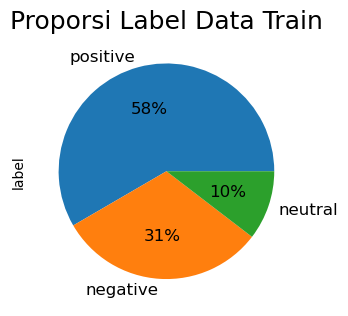

In [36]:
# Mendeskripsikan persentase label dari data train
df_train['label'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(3.5,3.5), fontsize=12)
plt.title('Proporsi Label Data Train', fontsize=18)
plt.show()

In [37]:
# Membuat kolom total char dan total word
df_train['total char'] = df_train['text_clean'].apply(lambda x : len(x))
df_train['total word'] = df_train['text_clean'].apply(lambda x : len(x.split()))
df_train.head()

,text,label,text_clean,total char,total word
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik tahu sudah pu...,339,47
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai apa...,82,14
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung tempat ...,155,25
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri saat unbo paket barang...,72,12
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh jadi mahasiswa jangan sombong dong kasih ...,179,28


In [38]:
# Mean total char dan total word

df_train[['total char', 'total word']].mean()

total char    151.565718
total word     23.168206
dtype: float64

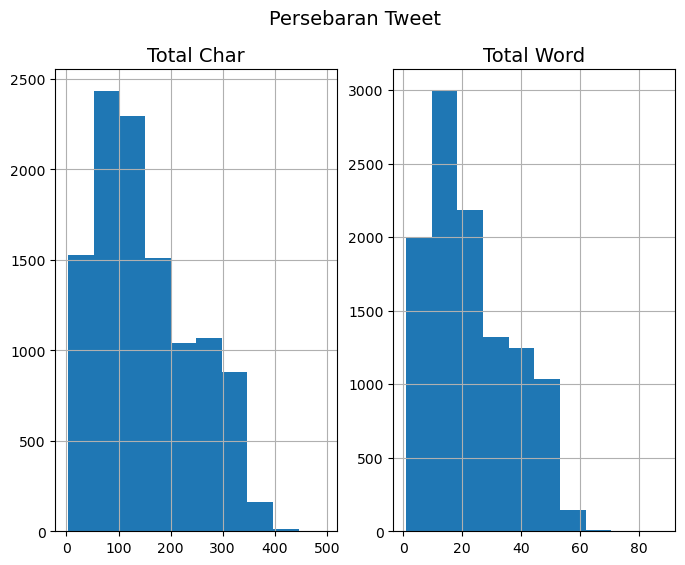

In [39]:
# Histogram Total Char and Total Word
fig, ax = plt.subplots(1,2, figsize=(8,6))
fig.suptitle('Persebaran Tweet', fontsize= 14)


df_train['total char'].hist(ax = ax[0])
ax[0].set_title('Total Char', fontsize= 14)
df_train['total word'].hist(ax = ax[1])
ax[1].set_title('Total Word', fontsize= 14)

plt.show()

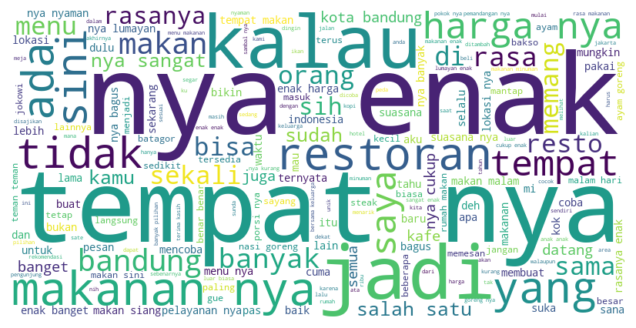

In [40]:
# Visualisasi kata yang sering muncul menggunakan wordcloud
text = df_train['text_clean'].str.cat(sep=' ')

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

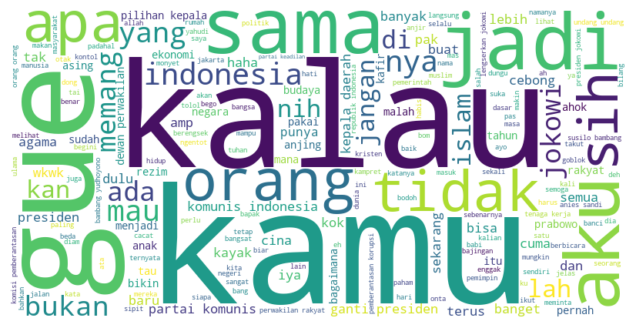

In [42]:
# Visualisasi kata yang sering muncul menggunakan wordcloud
text = df_test['text_clean'].str.cat(sep=' ')

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **4. Feature Extraction**

In [43]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('pickle/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('pickle/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [44]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('pickle/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


## **5. Prepare Train and Test Datasets**

In [45]:
file = open("pickle/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("pickle/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## **6. Training**

In [46]:
embed_dim = 256

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
model.add(SpatialDropout1D(0.76))
model.add(LSTM(32, dropout=0.77, recurrent_dropout=0.76))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=1, callbacks=None)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 88, 256)           25600000  
                                                                 
 spatial_dropout1d (Spatial  (None, 88, 256)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 32)                36992     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 25637091 (97.80 MB)
Trainable params: 25637091 (97.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10


35/35 [==============================] - 45s 1s/step - loss:

## **7. Evaluation**

In [47]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 2s 24ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       668
           1       0.78      0.78      0.78       231
           2       0.92      0.93      0.92      1288

    accuracy                           0.88      2187
   macro avg       0.84      0.84      0.84      2187
weighted avg       0.88      0.88      0.88      2187



## **8. Cross Validation**

In [48]:
# CV COBA

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 256

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
    model.add(SpatialDropout1D(0.76))
    model.add(LSTM(32, dropout=0.77, recurrent_dropout=0.76))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=0, callbacks=None)

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 2s 22ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       668
           1       0.84      0.77      0.81       231
           2       0.92      0.93      0.92      1288

    accuracy                           0.88      2187
   macro avg       0.86      0.84      0.85      2187
weighted avg       0.88      0.88      0.88      2187

69/69 [==============================] - 2s 22ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       668
           1       0.84      0.79      0.82       231
           2       0.93      0.92      0.93      1288

    accuracy                           0.89      2187
   macro avg       0.86      0.86      0.86      2187
weighted avg       0.89      0.89      0.89      2187

69/69 [==============================] - 2s 24ms/step
Training ke- 3
              precision    reca

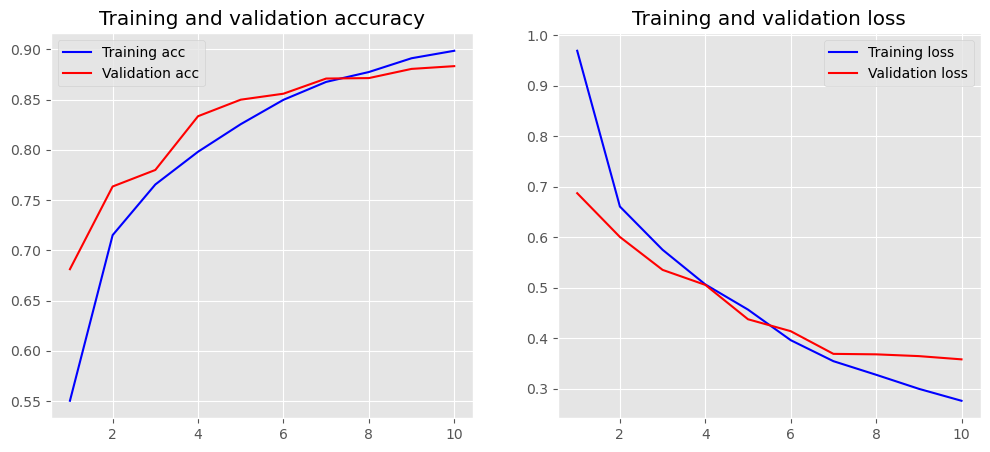

In [49]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [50]:
model.save('model.h5')
print('Model has created!')

C:\Users\asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


## **9. Predict**

In [87]:
input_text = """
cinta memang buta
"""

sentiment = ['negative', 'neutral', 'positive']

text = Cleansing(input_text)
text = [text]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 1s 515ms/step
Text:  cinta memang buta
Sentiment:  positive


In [84]:
df_test['text'] = df_test.text.apply(Cleansing)
temp = df_test.text.tolist()

sentiment = ['negative', 'neutral', 'positive']

predicted = tokenizer.texts_to_sequences(temp)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)

holder = [ ]
for i in range(0,len(prediction)):
    polarity = np.argmax(prediction[i])
    holder.append(sentiment[polarity])

412/412 [==============================] - 10s 23ms/step


In [85]:
df_test['sentiment'] = holder
df_test

,text,text_clean,sentiment
0,saat semua cowok berusaha melacak perhatian gu...,saat semua cowok berusaha melacak perhatian gu...,negative
1,siapa telat memberi tau kamu edan sarap gue be...,siapa telat memberi tau kamu edan sarap gue be...,negative
2,41 kadang aku berpikir aku tetap percaya tuhan...,41 kadang aku berpikir aku tetap percaya tuhan...,positive
3,aku aku ku tau matamu sipit dilihat mana aku,aku aku ku tau matamu sipit dilihat mana aku,negative
4,kaum cebong kafir kelihatan dongoknya awal tam...,kaum cebong kafir kelihatan dongoknya awal tam...,negative
...,...,...,...
13164,jangan asal berbicara ndasmu congor kamu sekat...,jangan asal berbicara ndasmu congor kamu sekat...,negative
13165,kasur mana enak kunyuk,kasur mana enak kunyuk,negative
13166,hati hati bisu dan bosan duh,hati hati bisu dan bosan duh,negative
13167,bom real mudah terdeteksi bom terkubur suatu l...,bom real mudah terdeteksi bom terkubur suatu l...,neutral


In [76]:
neg = df_test.loc[df_test['sentiment'] == 'negative'].text.tolist()
neu = df_test.loc[df_test['sentiment'] == 'neutral'].text.tolist()
pos = df_test.loc[df_test['sentiment'] == 'positive'].text.tolist()

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))

Pos: 620, Neu: 1881, Neg: 10668


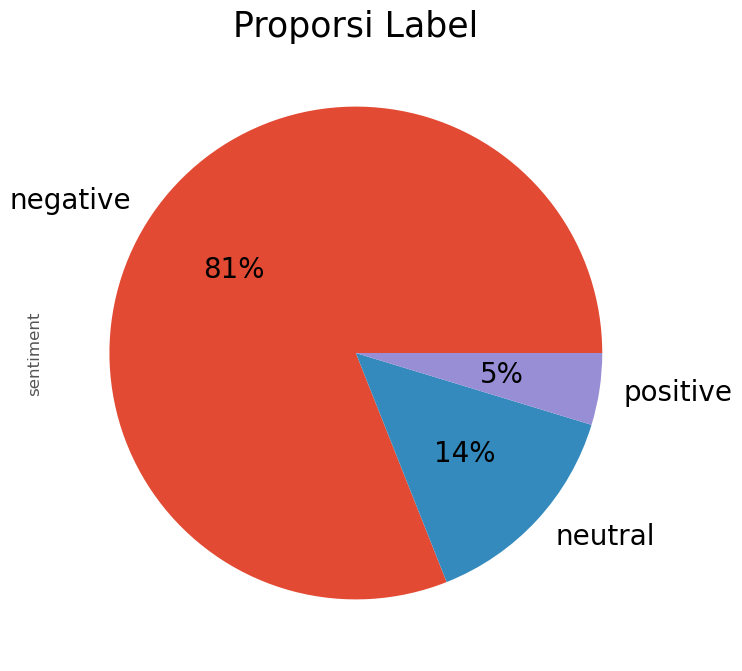

In [86]:
df_test['sentiment'].value_counts().plot(kind='pie', autopct='%1.00f%%', figsize=(8,8), fontsize = 20)
plt.title('Proporsi Label', fontsize=25)
plt.show()